# CS109b Final Project

# Milestone 5 CLASSICAL Models


by Danqing Wang, Wenshan Zheng, Zecai Liang


---

In [49]:
import pandas as pd
# import all data other than converted text data
x_full = pd.read_csv('data_feature_4865.csv')
y_full = pd.read_csv('y_full.csv')

In [50]:
# import converted text data from zecai
text_train = pd.read_csv('data_text_4865_train.csv')
text_test = pd.read_csv('data_text_4865_test.csv')
text_train.index = text_train['imdb_ids']
text_test.index = text_test['imdb_ids']
print text_train.shape
print text_test.shape

(3000, 284)
(1865, 284)


In [58]:
######### Run supplement functions block below before running this cell ########
x_train_notext, x_test_notext, y_train, y_test = generate_train_test_data(x_full, y_full)

In [59]:
x_train = pd.concat([x_train_notext, text_train], axis=1)
x_test = pd.concat([x_test_notext, text_test], axis=1)

In [61]:
x_train.to_csv("x_train.csv")
x_test.to_csv("x_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

## Supplement: functions that are used in the above meta-function:

In [51]:
##### part of the function to apply text analysis to a data series #####
#### to transform a text paragraph to bag-of-words than to one-hot coding


#----------------------------------------------------------------------------------------------------
### Input ###
        # data: a series for text analysis

        
### Output ###
        # the transformed data in one-hot coding
#----------------------------------------------------------------------------------------------------        



def text_to_matrix(data):
    
    import pandas as pd
    import numpy as np
    import re
    import warnings
    warnings.filterwarnings("ignore")
    
    
    
    ## --------------- Bag-of-Words --------------- ##
    
    ## string to list
    import re
    col_words = []
    
    for i in range(data.shape[0]):
    
        if type(data.iloc[i,0]) == str: 
            letters_only = re.sub("[^a-zA-Z]", " " , data.iloc[i,0]) # remove non-letter
            lower_case = letters_only.lower().split()   # Convert to lower case # Split into words
            
            # avoid downloading nltk
            # from NLTK stopwords https://pythonprogramming.net/stop-words-nltk-tutorial/
            stops = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 
                     'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 
                     'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 
                     's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
                     'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 
                     'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 
                     'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 
                     'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 
                     'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 
                     'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 
                     'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 
                     'it', 'how', 'further', 'was', 'here', 'than'} 
            meaningful_words = [w for w in lower_case if not w in stops]  # Remove stop words from "words"
            
            words = ( " ".join(meaningful_words))
    
        else: words = "NA"
       
        col_words.append(words)
        
        
    
    ## list to vector
    from sklearn.feature_extraction.text import CountVectorizer

    # Initialize the "CountVectorizer" object
    vectorizer = CountVectorizer(analyzer = "word",   
                                 tokenizer = None,    
                                 preprocessor = None, 
                                 stop_words = None,   
                                 max_features = 20000)

    data_array = vectorizer.fit_transform(col_words)
    data_array = pd.DataFrame(data_array.toarray())
    data_array.columns = vectorizer.get_feature_names()
    
    return data_array
    

### Function for Variable ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB', 'mpaa_reason']

In [52]:
##### Function to apply text analysis to a column with `colname` in the data file `filename`


#----------------------------------------------------------------------------------------------------
### Input ###
        # train: the train data in one-hot coding
        # test: the test data in one-hot coding
        # val_name:  variable name that's used in naming the columns as "val_name_PCi"
        # n_components: if value is int, the number of PCs to return
                       # if value between (0,1), the variance explained by the PCs returnd
        
### Output ###
        # data matrix of engineered feature, one for train data and one for test data
#----------------------------------------------------------------------------------------------------        


def text_analysis(train, test, val_name, n_components):
    
    ## turn each text paragraph into one-hot coding
    train_array = text_to_matrix(train)
    test_array = text_to_matrix(test)
    
    ## take the union set of words in train and text data as column
    ## words that don't show up are assigned 0
    align_column = pd.concat([train_array,test_array], axis=0).fillna(0)
    # keep only the gas-of-words from training data
    align_column = align_column[train_array.columns]
    
    ## split into train and text after aligning the columns
    train_array = align_column.iloc[0:train_array.shape[0], ]
    test_array = align_column.iloc[train_array.shape[0]:, ]
    
    ## PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components = n_components)
    pca.fit(train_array)
    train_new = pd.DataFrame(pca.transform(train_array), index = train.index)
    test_new = pd.DataFrame(pca.transform(test_array), index = test.index)
    test_new = test_new.fillna(value = 0)
    
    col_names = []
    for i in range(train_new.shape[1]):
        i_name = val_name + "_PC" + str(i+1)
        col_names.append(i_name)
        
    train_new.columns = col_names
    test_new.columns = col_names
    
    return (train_new, test_new)
    

### Function used in the following functions

In [250]:
### Function to convert to string list [u'Action', u'Adventure', u'Fantasy'] into dummy coding
## input: 
           # data = orignal data frame, 
           # val_name = name of the variable
## output: a data frame

def string_to_vector(data, val_name):
    
    from sklearn.feature_extraction.text import CountVectorizer
    
    # convert any np.nan to a string 'nan'
    data[val_name][pd.isnull(data[val_name])] = 'nan'
    
    vectorizer = CountVectorizer(analyzer = "word",   
                                             tokenizer = None,    
                                             preprocessor = None, 
                                             stop_words = None,   
                                             max_features = 50000)

    val_data = vectorizer.fit_transform(data[val_name])
    df_val = pd.DataFrame(val_data.toarray())
    df_val.columns = vectorizer.get_feature_names()
    df_val.index = data.index
    
    return df_val

### Function for Variable ['director', 'writer']

In [251]:
### Function considers a particular feature of interest (e.g. director, writer) 
### and picks out the top val_n most important value in each genre
### Input: 
# - train_feature: df with 2500 train observations, all feature columns, indexed with imdb_ids
# - train_genre: df with 2500 train observations, all genre columns, indexed with imdb_ids
# - test_feature: df with 2500 test observations, all feature columns, indexed with imdb_ids 
# - test_genre: df with 2500 test observations, all genre columns, indexed with imdb_ids
# - val_name # feature of interest, eg. director
# - val_n # number of top values to take, eg. 1
### Output:
# - train_val: df with 2500 train observations, new columns of top directors, indexed with imdb_ids
# - test_val: df with 2500 test observations, new columns of top directors, indexed with imdb_ids

def top_features(train_feature, train_genre, test_feature, test_genre,
                val_name = 'director', val_n = 1):

    # convert feature of interest into dummy variables in train set and test set
    feature_val_train = string_to_vector(train_feature, val_name)
    feature_val_test = string_to_vector(test_feature, val_name)

    # create a dataframe with columns consisting of all directors and all genres, rows are movie entries 
    feature_val_genre = pd.concat([feature_val_train, train_genre], axis = 1)
    
    # generate list of top directors in each genre 
    val_list = []
    for i in train_genre.columns:
        sum_val_in_genre = feature_val_genre.ix[feature_val_genre[i] == 1, range(feature_val_train.shape[1]-1)].sum(axis = 0)
        sum_val_in_genre_sorted = sum_val_in_genre.sort(inplace=False, ascending = False)
        for j in range(val_n):
            top_val_in_genre = sum_val_in_genre_sorted.index[j]
            val_list.append(top_val_in_genre)      

    # output dataframes of movies with new columns
    train_val = feature_val_train.ix[:, val_list] 
    test_val = feature_val_test.ix[:, val_list]
    
    # replace any NA vaalues in the test set with 0
    test_val = test_val.fillna(value = 0)
    
    # rename columns as director1, director2, etc
    col_names = []
    for i in range(train_val.shape[1]):
            i_name = val_name + str(i)
            col_names.append(i_name)
    train_val.columns = col_names
    test_val.columns = col_names

    return(train_val, test_val)

In [254]:
x_train.columns

Index([u'year', u'rating', u'votes', u'popularity_TMDB', u'runtime_TMDB',
       u'mpaa_PC1', u'mpaa_PC2', u'mpaa_PC3', u'mpaa_PC4', u'mpaa_PC5',
       ...
       u'text_PC274', u'text_PC275', u'text_PC276', u'text_PC277',
       u'text_PC278', u'text_PC279', u'text_PC280', u'text_PC281',
       u'text_PC282', u'text_PC283'],
      dtype='object', length=344)

### Function for Variable ['cast','production company']

In [55]:
### Function considers a particular feature of interest (e.g. cast, production companies) 
### and picks out the top val_n most important value in each genre
### and then performs PCA, picks out the top pca_n numbers of components
### Input: 
# - train_feature: df with 2500 train observations, all feature columns, indexed with imdb_ids
# - train_genre: df with 2500 train observations, all genre columns, indexed with imdb_ids
# - test_feature: df with 2500 test observations, all feature columns, indexed with imdb_ids 
# - test_genre: df with 2500 test observations, all genre columns, indexed with imdb_ids
# - val_name # feature of interest, eg. director
# - val_n # number of top values to take, eg. 5
# - pca_n # number of pca components to retain, eg. 5
### Output:
# - train_val: df with 3000 train observations, columns as pca components, indexed with imdb_ids
# - test_val: df with 2000 test observations, columns as pca components, indexed with imdb_ids

def top_features_pca(train_feature, train_genre, test_feature, test_genre,
                     val_name = 'cast',
                     val_n = 5,
                     pca_n = 5):
    
    ## Step 1, pick top casts in each genre using top_feature function 
    train_val, test_val = top_features(train_feature = train_feature,
                    train_genre = train_genre,
                    test_feature = test_feature,
                    test_genre = test_genre,
                    val_name = val_name,
                    val_n = val_n)
    
    # replace any NA values in test set with 0 (or will have problem in pca.transform)
    test_val = test_val.fillna(value=0)

    ## Step 2, perform PCA
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components = pca_n, svd_solver = "full") # keep the first pca_n PCs
    pca = pca.fit(train_val)
    train_pca = pd.DataFrame(pca.transform(train_val), index = train_val.index)
    test_pca = pd.DataFrame(pca.transform(test_val), index = test_val.index)

    ## Step 3, rename the columns as cast_PC1, cast_PC2, etc. 
    col_names = []
    for i in range(pca_n):
            i_name = val_name + "_PC" + str(i+1)
            col_names.append(i_name)
    train_pca.columns = col_names
    test_pca.columns = col_names

    return (train_pca, test_pca)

### Function for Variable ['animatino department', 'original music']

In [56]:
### Function considers a particular feature of interest (e.g. animation department, original music) 
### and counts the number of member occurance in each movie 
### Input: 
# - train_feature: df with 2500 train observations, all feature columns, indexed with imdb_ids
# - test_feature: df with 2500 test observations, all feature columns, indexed with imdb_ids 
# - val_name # feature of interest, eg. animation department
### Output:
# - train_count: df with 2500 train observations, new column of count, indexed with imdb_ids
# - test_count: df with 2500 test observations, new column of count, indexed with imdb_ids

def feature_to_count(train_feature, train_genre, test_feature, test_genre,
                val_name = 'animation department'):
    
    # convert column to number of counts of members 
    train_count = pd.DataFrame(string_to_vector(train_feature, val_name).ix[:,:-1].sum(axis=1), 
                               columns = {val_name + ' count'})
    test_count = pd.DataFrame(string_to_vector(test_feature, val_name).ix[:,:-1].sum(axis=1), 
                              columns = {val_name + ' count'})
    
    return(train_count, test_count)

## Function to combine everything other than text

In [57]:
###### Function to generate train and test data for classification models #######
### ------ Input ---------- ###
# feature_data: a data frame with original features from IMDB and TMDB
# genre_data: a data grame with genres (already merged turned into one-hot coding), 
#             matching the feature_data by 'imdb_ids'
# n_sample: the number of data points to sample from the input data frame to fit model
# train_ratio: the percentage of training data among sampled data
# ran_state: seed for random sampling


def generate_train_test_data(x_full, y_full):
    
    import pandas as pd
    import numpy as np
    import re
    import random
    import warnings
    warnings.filterwarnings("ignore")

    # ------------------------------------------------------------------------------------------------------ #     
    
    ### split into train and test data ###
    
    x_train = x_full[:3000]
    x_test = x_full[3000:]
    y_train = y_full[:3000]
    y_test = y_full[3000:]
    
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variable Group 1: ['year', 'rating', 'votes', 'popularity_TMDB', 'runtime_TMDB'] ###

    val_group1 = ['year', 'rating', 'votes', 'popularity_TMDB', 'runtime_TMDB']
    
    ## missing value imputation ##
    # use the mean from train data to fill test data 

    # 'year', 'rating', 'votes' have missing values as 'NaN', fill by column mean
    x_train.ix[x_train['year'].isnull(), 'year'] = x_train['year'].mean()
    x_test.ix[x_test['year'].isnull(), 'year'] = x_train['year'].mean()

    x_train.ix[x_train['rating'].isnull(), 'rating'] = x_train['rating'].mean()
    x_test.ix[x_test['rating'].isnull(), 'rating'] = x_train['rating'].mean()

    x_train.ix[x_train['votes'].isnull(), 'votes'] = x_train['votes'].mean()
    x_test.ix[x_test['votes'].isnull(), 'votes'] = x_train['votes'].mean()

    # 'popularity_TMDB' have missing values as 0, replace by column mean
    x_train.ix[x_train['popularity_TMDB'] == 0, 'popularity_TMDB'] = x_train['popularity_TMDB'].mean()
    x_test.ix[x_test['popularity_TMDB'] == 0, 'popularity_TMDB'] = x_train['popularity_TMDB'].mean()
    
    # 'runtime_TMDB' have missing values as 0 and 'NaN'
    value = x_train['runtime_TMDB'].mean()
    x_train.ix[x_train['runtime_TMDB'] == 0, 'runtime_TMDB'] = value
    x_train.ix[x_train['runtime_TMDB'].isnull(), 'runtime_TMDB'] = value
    x_test.ix[x_test['runtime_TMDB'] == 0, 'runtime_TMDB'] = value
    x_test.ix[x_test['runtime_TMDB'].isnull(), 'runtime_TMDB'] = value
    
    
    ## use x_train_new, x_test_new to record the transformed data
    x_train_group1 = x_train[val_group1]
    x_test_group1 = x_test[val_group1]

    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 2: ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB', 'mpaa_reason'] ###

    ## combine the text in ['title', 'plot', 'plot outline', 'overview_TMDB', 'tagline_TMDB']

#     x_train_text = x_train['title'].str.cat([x_train['plot'], x_train['plot outline'], 
#                               x_train['overview_TMDB'], x_train['tagline_TMDB']], 
#                               na_rep = " ")
#     x_train_text = pd.DataFrame(x_train_text, index = x_train.index)

#     x_test_text = x_test['title'].str.cat([x_test['plot'], x_train['plot outline'], 
#                               x_test['overview_TMDB'], x_test['tagline_TMDB']], 
#                               na_rep = " ")
#     x_test_text = pd.DataFrame(x_test_text, index = x_test.index)

#     ## apply text analysis on combined text and return the top 30 PCs
#     x_train_group2, x_test_group2 = text_analysis(x_train_text, x_test_text,
#                                              val_name = 'text', n_components = 30)

    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 3: [mpaa_reason'] ###

    ## apply text analysis on 'mpaa_reason' and return thr PCs that cover 60% variance
    x_train_mpaa = pd.DataFrame(x_train['mpaa_reason'], index = x_train.index)
    x_test_mpaa = pd.DataFrame(x_test['mpaa_reason'], index = x_test.index)
    
    x_train_group3, x_test_group3 = text_analysis(x_train_mpaa, x_test_mpaa,
                                             val_name = 'mpaa', n_components = 10)
    
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 4: ['director', 'cast', 'production company', 'writer'] ###
    
    x_train_group4_1, x_test_group4_1 = top_features(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'director',
                                        val_n = 1)
    
    x_train_group4_2, x_test_group4_2 = top_features(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'writer',
                                        val_n = 1)

    x_train_group4_3, x_test_group4_3 = top_features_pca(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                         val_name = 'cast',
                                         val_n = 5,
                                         pca_n = 10)

    x_train_group4_4, x_test_group4_4 = top_features_pca(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                         val_name = 'production companies',
                                         val_n = 5,
                                         pca_n = 5)
     
    x_train_group4 = pd.concat([x_train_group4_1, x_train_group4_2,
                               x_train_group4_3, x_train_group4_4], axis = 1)
    x_test_group4 = pd.concat([x_test_group4_1, x_test_group4_2,
                               x_test_group4_3, x_test_group4_4], axis = 1)
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 5: ['animation department', 'original music'] ###
    
    # return x_train_group5, x_test_group5
    
    x_train_group5_1, x_test_group5_1 = feature_to_count(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'animation department')

    x_train_group5_2, x_test_group5_2 = feature_to_count(train_feature = x_train, train_genre = y_train,
                                        test_feature = x_test, test_genre = y_test,
                                        val_name = 'original music')
    
    
    x_train_group5 = pd.concat([x_train_group5_1, x_train_group5_2], axis = 1)
    x_test_group5 = pd.concat([x_test_group5_1, x_test_group5_2], axis = 1)
    
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Variables Group 6: ['countries'] ###
    x_train_country = text_to_matrix(pd.DataFrame(x_train['countries'], index = x_train.index))
    x_test_country = text_to_matrix(pd.DataFrame(x_test['countries'], index = x_test.index))
    
    x_train_country.index = x_train.index
    x_test_country.index = x_test.index
    
      # count the number of countries for each movie
    x_train_group6_1 = pd.DataFrame(x_train_country.sum(axis = 1), columns = ['country_n'])
    x_test_group6_1 = pd.DataFrame(x_test_country.sum(axis = 1), columns = ['country_n'])
    
      # keep the information of major countries
    country_major = ['usa', 'france', 'uk', 'germany', 'italy', 'canada', 'japan', 'india', 'spain']
    x_train_group6_2 = x_train_country[country_major]
    x_train_group6_2.columns = ['country_usa', 'country_france', 
                                 'country_uk', 'country_germany',
                                 'country_italy', 'country_canada', 
                                 'country_japan', 'country_india', 'country_spain'] 
    x_test_group6_2 = x_test_country[country_major]
    x_test_group6_2.columns = ['country_usa', 'country_france', 
                                 'country_uk', 'country_germany',
                                 'country_italy', 'country_canada', 
                                 'country_japan', 'country_india', 'country_spain']
    
    # ------------------------------------------------------------------------------------------------------ # 
    ### Combine Engineered Features ###
    x_train_new = pd.concat([x_train_group1, x_train_group3, 
                             x_train_group4, x_train_group5,
                             x_train_group6_1, x_train_group6_2], axis=1)
    
    x_test_new = pd.concat([x_test_group1, x_test_group3, 
                             x_test_group4, x_test_group5,
                            x_test_group6_1, x_test_group6_2], axis=1)
    
    x_train_new.index = x_train['imdb_ids']
    x_test_new.index = x_test['imdb_ids']
    
     
    return (x_train_new, x_test_new, y_train, y_test)

---
# Part 2. Performance Metrics

ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

We considered three metircs to use:

#### F1 Score: #### 
- For each movie to be predicted, we use the `f1_score` function from `sklearn.metrics` package to compare the predicted value (23-long vector with 0 and 1 for each genre) and true value. To start with, we can calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- We choose F1 score because we care about both false positive and false negative mistakes. For now we are giving them the same weights, so we take the harmonic mean of precision and recall. But this can be further adjusted depending on the application of this prediction (whether it's worse to mis-classified a genre or to miss a genre).

#### weighted F1 Score: #### 
- We can also use the 'weighted average' for F1 score: calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This accounts for inbalanced data.

#### IoU Score ####
- We also exlored another metric: Intersection over Union (IoU). Accuracy score here is defined as (intersection between real and predicted vectors) / (union between real and predicted vectors). It also moniters both false positive and false negtive mistakes.

For the following model tuning, we'll use unweighted F1 score.

#### The function to calculate averaged F1 score:

In [64]:
# Function f1_genre
# input: two pandas dataframes, 
    # genre_real: predicted values
    # genre_predict: real values
# output: mean f1 score of each class
def f1_genres(genre_real, genre_predict):
    count_row = len(genre_real)
    if count_row == 0:
        print "No data in dataframe!"
        return
    if count_row != len(genre_predict):
        print "Different length of predicted and real dataframes!"
        return
    count_col = len(genre_real.columns)
    if count_col == 0:
        print "No data in dataframe!"
        return
    if count_col != len(genre_predict.columns):
        print "Different genres of predicted and real dataframes!"
        return
    score = 0
    for i in range(count_col):
        score += f1_score(genre_real[genre_real.columns.values[i]], genre_predict[genre_predict.columns.values[i]])
    score = score/count_col
    return(score)

#### Function to calculate the aveage IoU score:

In [65]:
# Function score_genre
# input: two pandas dataframes, 
    # genre_real: predicted values
    # genre_predict: real values
# output: mean accuracy of prediction
# accuracy score here is defined as 
    # (intersection between real and predicted vectors) / (union between real and predicted vectors)

def score_genre(genre_real, genre_predict):
    count_row = len(genre_real)
    if count_row == 0:
        print "No data in dataframe!"
        return
    if count_row != len(genre_predict):
        print "Different length of predicted and real dataframes!"
        return
    count_col = len(genre_real.columns)
    if count_col == 0:
        print "No data in dataframe!"
        return
    if count_col != len(genre_predict.columns):
        print "Different genres of predicted and real dataframes!"
        return
    accuracy_genre = 0.0
    for i in range(count_row):
        count_intersection = 0.0
        count_unity = 0.0
        accuracy_temp = 0.0
        for j in range(len(genre_real.columns)):
            if genre_real.iloc[i][j] == 1 or genre_predict.iloc[i][j] == 1:
                count_unity += 1.0
            if genre_real.iloc[i][j] == 1 and genre_predict.iloc[i][j] == 1:
                count_intersection += 1.0 
        if count_unity == 0: # a few ovservations has no genre assigned, delete these values from evaluation
            count_row = count_row - 1
        else:
            accuracy_temp = count_intersection / count_unity
            accuracy_genre += accuracy_temp
    if count_row <= 0:
        print "No meaning value!"
        return
    return (accuracy_genre/count_row)

---
# Part 3. Benchmark Models

In [185]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import f1_score
import scipy as sp
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [186]:
## read in datasets
x_test = pd.read_csv('x_test.csv',index_col=0)
x_train = pd.read_csv('x_train.csv',index_col=0)
y_test = pd.read_csv('y_test.csv',index_col=0)
y_train = pd.read_csv('y_train.csv',index_col=0)

y_train.index = y_train['Unnamed: 0.1']
y_train = y_train.ix[:,1:]
y_test.index = y_test['Unnamed: 0.1']
y_test = y_test.ix[:,1:]

In [187]:
x_train.head()

year  rating  votes  popularity_TMDB  runtime_TMDB  mpaa_PC1  \
imdb_ids                                                                   
220440    1982.0     7.8   15.0         0.000008     60.000000 -0.266757   
136227    1987.0     7.4    9.0         0.033750     75.000000 -0.266757   
1686303   2010.0     2.5  127.0         0.000715     92.000000 -0.266757   
1103253   2007.0     6.9   12.0         0.001205     87.957095 -0.266757   
459149    1968.0     6.6   13.0         0.000215      5.000000 -0.266757   

          mpaa_PC2  mpaa_PC3  mpaa_PC4  mpaa_PC5     ...      text_PC274  \
imdb_ids                                             ...                   
220440    0.003165 -0.020917 -0.003125 -0.002995     ...       -0.023968   
136227    0.003165 -0.020917 -0.003125 -0.002995     ...        0.015472   
1686303   0.003165 -0.020917 -0.003125 -0.002995     ...        0.002609   
1103253   0.003165 -0.020917 -0.003125 -0.002995     ...       -0.004630   
459149    0.003165 -0.020917 -0.003125 -0.002995     ...        0.021210   

          text_PC275  text_PC276  text_PC277  text_PC278  text_PC279  \
imdb_ids                                                               
220440      0.036881   -0.025464   -0.015310    0.031323    0.004171   
136227     -0.050069    0.015762   -0.035380   -0.033916   -0.018753   
1686303    -0.027212   -0.008744    0.016721   -0.057564    0.060930   
1103253     0.001137    0.015534   -0.007925    0.007900   -0.011010   
459149     -0.000370   -0.027514   -0.022457   -0.006109    0.012290   

          text_PC280  text_PC281  text_PC282  text_PC283  
imdb_ids                                                  
220440     -0.016361   -0.019913   -0.037601    0.002096  
136227     -0.004565    0.013226   -0.064336    0.003758  
1686303    -0.001269   -0.062099   -0.033340    0.029117  
1103253     0.000130    0.011633   -0.006502   -0.009786  
459149     -0.035121   -0.010789   -0.024256    0.001676  

[5 rows x 344 columns]

In [188]:
y_train.head()

Act_Adven_West  Mus_Bio_His_War_Doc  Sh_Ani_Fam  Fant_SF  \
Unnamed: 0.1                                                             
220440                     0                    1           0        0   
136227                     0                    0           0        0   
1686303                    0                    0           0        0   
1103253                    0                    0           0        0   
459149                     1                    0           1        0   

              Mys_Cri_Hor_Thr  Romance  Drama  Comedy  
Unnamed: 0.1                                           
220440                      0        0      0       0  
136227                      0        0      0       0  
1686303                     1        0      0       1  
1103253                     0        0      1       0  
459149                      0        0      1       0

In [189]:
### standardize
scaler = preprocessing .StandardScaler().fit(x_train)
x_train_np = scaler.transform(x_train)
x_test_np = scaler.transform(x_test)

indexs_train = x_train.index
indexs_test = x_test.index
x_train = pd.DataFrame(x_train_np, index = indexs_train, columns = x_train.columns)
x_test = pd.DataFrame(x_test_np, index = indexs_test, columns = x_test.columns)

## 3.1 Baseline Model
We'll quickly go through classification models without feature selection or model tuning, and have a sense of their base peformance.

#### methods support multilabel classification:

In [190]:
# KNN
random.seed(0)
knn = KNN(n_neighbors=1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)

score_knn = f1_genres(y_test, y_pred)
print "F1 Score:", score_knn

F1 Score: 0.243856036762


In [191]:
# Decision Tree
random.seed(0)
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)

score_tree = f1_genres(y_test, y_pred)
print "F1 Score:", score_tree

F1 Score: 0.394552430286


In [193]:
# Random Forest
random.seed(0)
rf = RandomForest()
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_pred= pd.DataFrame(y_pred, columns = y_test.columns.values)

score_rf = f1_genres(y_test, y_pred)
print "F1 Score:", score_rf

F1 Score: 0.275903020404


#### Other classifiers that don't support multilabel classification, thus need to fit classifier for each genre, then combine:

In [194]:
# Unweighted logistic regression
random.seed(123)

genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    unweighted_logistic = LogisticRegression()
    unweighted_logistic.fit(x_train, y_train[col])
    genre_pred[col]= unweighted_logistic.predict(x_test)

score_unweighted_log = f1_genres(y_test, genre_pred)
print "F1 Score:", score_unweighted_log

F1 Score: 0.586089398948


In [195]:
# weighted logistic regression
random.seed(42)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    weighted_logistic = LogisticRegression(class_weight='balanced')
    weighted_logistic.fit(x_train, y_train[col])
    genre_pred[col]= weighted_logistic.predict(x_test)

score_weighted_log = f1_genres(y_test, genre_pred)
print "F1 Score:", score_weighted_log

F1 Score: 0.587911244622


In [196]:
#LDA
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    lda = LDA()
    lda.fit(x_train, y_train[col])
    genre_pred[col]= lda.predict(x_test)

score_lda = f1_genres(y_test, genre_pred)
print "F1 Score:", score_lda

F1 Score: 0.579513501777


In [197]:
#QDA
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    qda = QDA()
    qda.fit(x_train, y_train[col])
    genre_pred[col]= qda.predict(x_test)

score_qda = f1_genres(y_test, genre_pred)
print "F1 Score:", score_qda

F1 Score: 0.369604677961


In [274]:
# SVM
random.seed(0)
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values

for col in y_train.columns:
    svm = SVC(C=5, class_weight='balanced')
    svm.fit(x_train, y_train[col])
    genre_pred[col]= svm.predict(x_test)

score_svm_nottuned = f1_genres(y_test, genre_pred)
print "F1 Score:", score_svm_nottuned

F1 Score: 0.577339818939


In [275]:
#Score Dataframe
score_df = pd.DataFrame({'KNN': score_knn, 
                         'Tree': score_tree,
                         'RF': score_rf,
                         'Unweighted Logistic': score_unweighted_log,
                         'Weighted Logistic': score_weighted_log,
                         'LDA': score_lda,
                         'QDA': score_qda,                        
                         'Weighted SVM': score_svm_nottuned,
                        'Tuned SVM':score_svm}, index = ['f1_score'])
score_df

KNN       LDA       QDA        RF      Tree  Tuned SVM  \
f1_score  0.243856  0.579514  0.369605  0.275903  0.394552   0.608692   

          Unweighted Logistic  Weighted Logistic  Weighted SVM  
f1_score             0.586089           0.587911       0.57734

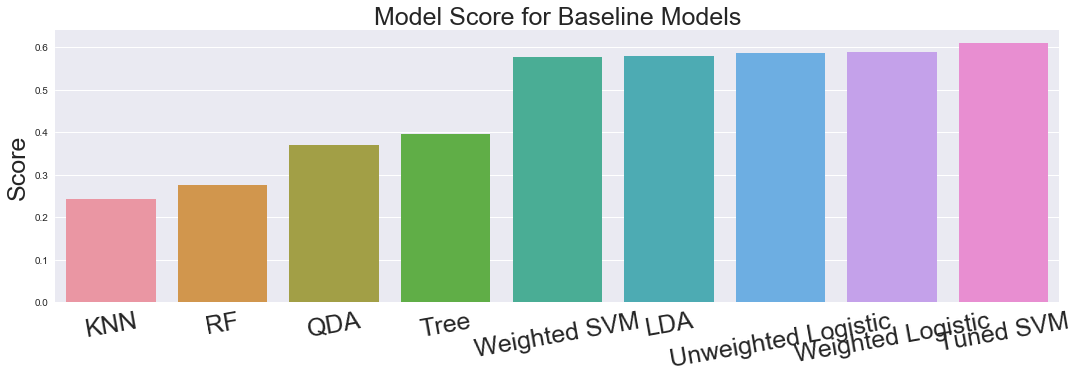

In [279]:
# score_df.plot(kind = "bar")
# plt.title("Model Score for Un-tuned Baseline Models")
# plt.show()



fig, ax = plt.subplots(figsize=(18,5))

ax = sns.barplot(data=score_df,
                 order = ['KNN', 'RF', 'QDA', 'Tree',
                          'Weighted SVM', 'LDA', 'Unweighted Logistic', 'Weighted Logistic','Tuned SVM'])
ax.set_ylabel('Score', fontsize = 25)
ax.set_title('Model Score for Baseline Models', fontsize = 25)
plt.xticks(rotation=10,fontsize = 25)
plt.show()


## 3.2 SVM

In [271]:
genre_pred = pd.DataFrame(index = x_test.index) # dataframe to store predicted values
c = range(-7, 7)

for col in y_train.columns:
    k_cv = 5
    score_cv = []
    for i in range(len(c)):
        # fit regularized logistic regression model on training set      
        svm = SVC(C=10**c[i], class_weight='balanced')
        score_cv += [sum(cross_val_score(svm, x_train, y_train[col], cv = k_cv, scoring = F_score_cv)) / k_cv]
    # find best score and corresponding tuning parameter
    C_best = 10**c[np.argmax(score_cv)]
    print col, C_best
    svm = SVC(class_weight='balanced',  C = C_best)
    svm.fit(x_train, y_train[col])
    genre_pred[col]= svm.predict(x_test)

score_svm = f1_genres(y_test, genre_pred)
print score_svm

Act_Adven_West 1
Mus_Bio_His_War_Doc 1
Sh_Ani_Fam 1
Fant_SF 1
Mys_Cri_Hor_Thr 1
Romance 1
Drama 1
Comedy 1
0.608691818274


The F1 score of tuned SVM is: 0.6087